In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [14]:
# 加载数据集
data = pd.read_csv('cleaned_data.csv')
print('数据基本信息：')
data.info()

数据基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Fe            82 non-null     float64
 1   Si            82 non-null     float64
 2   B             82 non-null     float64
 3   Nb            82 non-null     float64
 4   Zr            82 non-null     float64
 5   Cu            82 non-null     float64
 6   Ni            82 non-null     float64
 7   C             82 non-null     float64
 8   P             82 non-null     float64
 9   Co            82 non-null     float64
 10  Gd            82 non-null     float64
 11  Mo            82 non-null     float64
 12  Al            82 non-null     float64
 13  Y             82 non-null     float64
 14  Mn            82 non-null     float64
 15  Cr            82 non-null     float64
 16  Ta            82 non-null     float64
 17  DO3           82 non-null     float64
 18  BCC           82 non-nul

In [15]:
# 提取特征变量x和目标变量y（Ms和Hc）
x = data.drop(columns=['Ms', 'Hc'])
y = data[['Ms', 'Hc']]

# 划分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 创建多输出线性回归模型并拟合数据
model = LinearRegression()
model.fit(x_train, y_train)

# 在测试集上进行预测
y_pred = model.predict(x_test)

In [19]:
# 计算并输出性能指标
mse_ms = mean_squared_error(y_test['Ms'], y_pred[:, 0])
r2_ms = r2_score(y_test['Ms'], y_pred[:, 0])
mse_hc = mean_squared_error(y_test['Hc'], y_pred[:, 1])
r2_hc = r2_score(y_test['Hc'], y_pred[:, 1])

print(f"Ms均方误差(MSE): {mse_ms}")
print(f"Ms决定系数(R²): {r2_ms}")
print(f"Hc均方误差(MSE): {mse_hc}")
print(f"Hc决定系数(R²): {r2_hc}")

Ms均方误差(MSE): 401.6731608528111
Ms决定系数(R²): 0.7819325815304402
Hc均方误差(MSE): 7221.594782492016
Hc决定系数(R²): 0.6308574282575661


In [20]:
# 定义复合指标参数（调整λ以平衡Ms和Hc的重要性）
lambda_param = 0.5  # 示例值，需根据需求调整

# 初始化当前最佳复合指标
current_composite = (y_train['Ms'] - lambda_param * y_train['Hc']).max()
print(f"初始最佳复合指标（Ms - λ*Hc）: {current_composite}")

初始最佳复合指标（Ms - λ*Hc）: 223.12431665092774


In [21]:
# 加载候选搜索空间
test_data = pd.read_csv("test_data.csv")
x_search = test_data[x.columns]  # 确保特征列一致

In [22]:
# 迭代优化参数
iterations = 15
iteration_best = [current_composite]

In [24]:
for i in range(iterations):
    # 从搜索空间中随机采样
    new_alloys = x_search.sample(5, random_state=i)
    
    # 预测候选样本的Ms和Hc
    y_pred_new = model.predict(new_alloys)
    pred_ms = y_pred_new[:, 0]
    pred_hc = y_pred_new[:, 1]
    
    # 计算复合指标和期望改进
    pred_composite = pred_ms - lambda_param * pred_hc
    improvement = pred_composite - current_composite
    ei = np.where(improvement > 0, improvement, 0)
    
    # 选择最优样本
    best_idx = np.argmax(ei)
    best_alloy = new_alloys.iloc[[best_idx]]
    best_ms = pred_ms[best_idx]
    best_hc = pred_hc[best_idx]
    
    # 输出迭代信息
    print(f"\n迭代 {i+1}/{iterations}")
    print("选中样本特征：")
    print(best_alloy)
    print(f"预测 Ms: {best_ms:.2f}, Hc: {best_hc:.2f}")
    print(f"复合指标改进: {ei[best_idx]:.2f}")
    
    # 更新训练集（假设预测值即实验值）
    x_train = pd.concat([x_train, best_alloy], ignore_index=True)
    y_train = pd.concat([y_train, pd.DataFrame({'Ms': [best_ms], 'Hc': [best_hc]})], 
                       ignore_index=True)
    
    # 重新训练模型
    model.fit(x_train, y_train)
    
    # 更新当前最佳复合指标
    current_composite = (y_train['Ms'] - lambda_param * y_train['Hc']).max()
    iteration_best.append(current_composite)
    print(f"更新后最佳复合指标: {current_composite:.2f}")



迭代 1/15
选中样本特征：
      Fe   Si     B    Nb   Zr   Cu     Ni    C     P   Co  ...    Mn    Cr  \
18  59.9  0.0  1.55  9.59  0.0  0.0  17.38  0.0  0.08  0.0  ...  0.79  4.11   

     Ta  DO3  BCC  FCC  HCP  Orthorhombic  hexagonal  Tetragonal  
18  0.0  0.0  0.0  0.0  1.0           1.0        1.0         0.0  

[1 rows x 24 columns]
预测 Ms: -67.45, Hc: 94.03
复合指标改进: 0.00
更新后最佳复合指标: 223.12

迭代 2/15
选中样本特征：
     Fe   Si      B   Nb   Zr   Cu   Ni    C      P     Co  ...   Mn   Cr  \
6  71.4  0.0  16.91  0.0  0.0  0.0  0.0  0.0  22.53  22.51  ...  0.0  0.0   

    Ta  DO3  BCC  FCC  HCP  Orthorhombic  hexagonal  Tetragonal  
6  0.0  1.0  1.0  0.0  1.0           1.0        0.0         0.0  

[1 rows x 24 columns]
预测 Ms: 518.41, Hc: 443.62
复合指标改进: 73.48
更新后最佳复合指标: 296.60

迭代 3/15
选中样本特征：
       Fe   Si    B    Nb   Zr   Cu    Ni    C     P   Co  ...   Mn    Cr  \
12  74.68  0.0  0.0  1.62  0.0  0.0  5.72  0.0  3.17  0.0  ...  6.1  0.31   

     Ta  DO3  BCC  FCC  HCP  Orthorhombic  hexagonal  

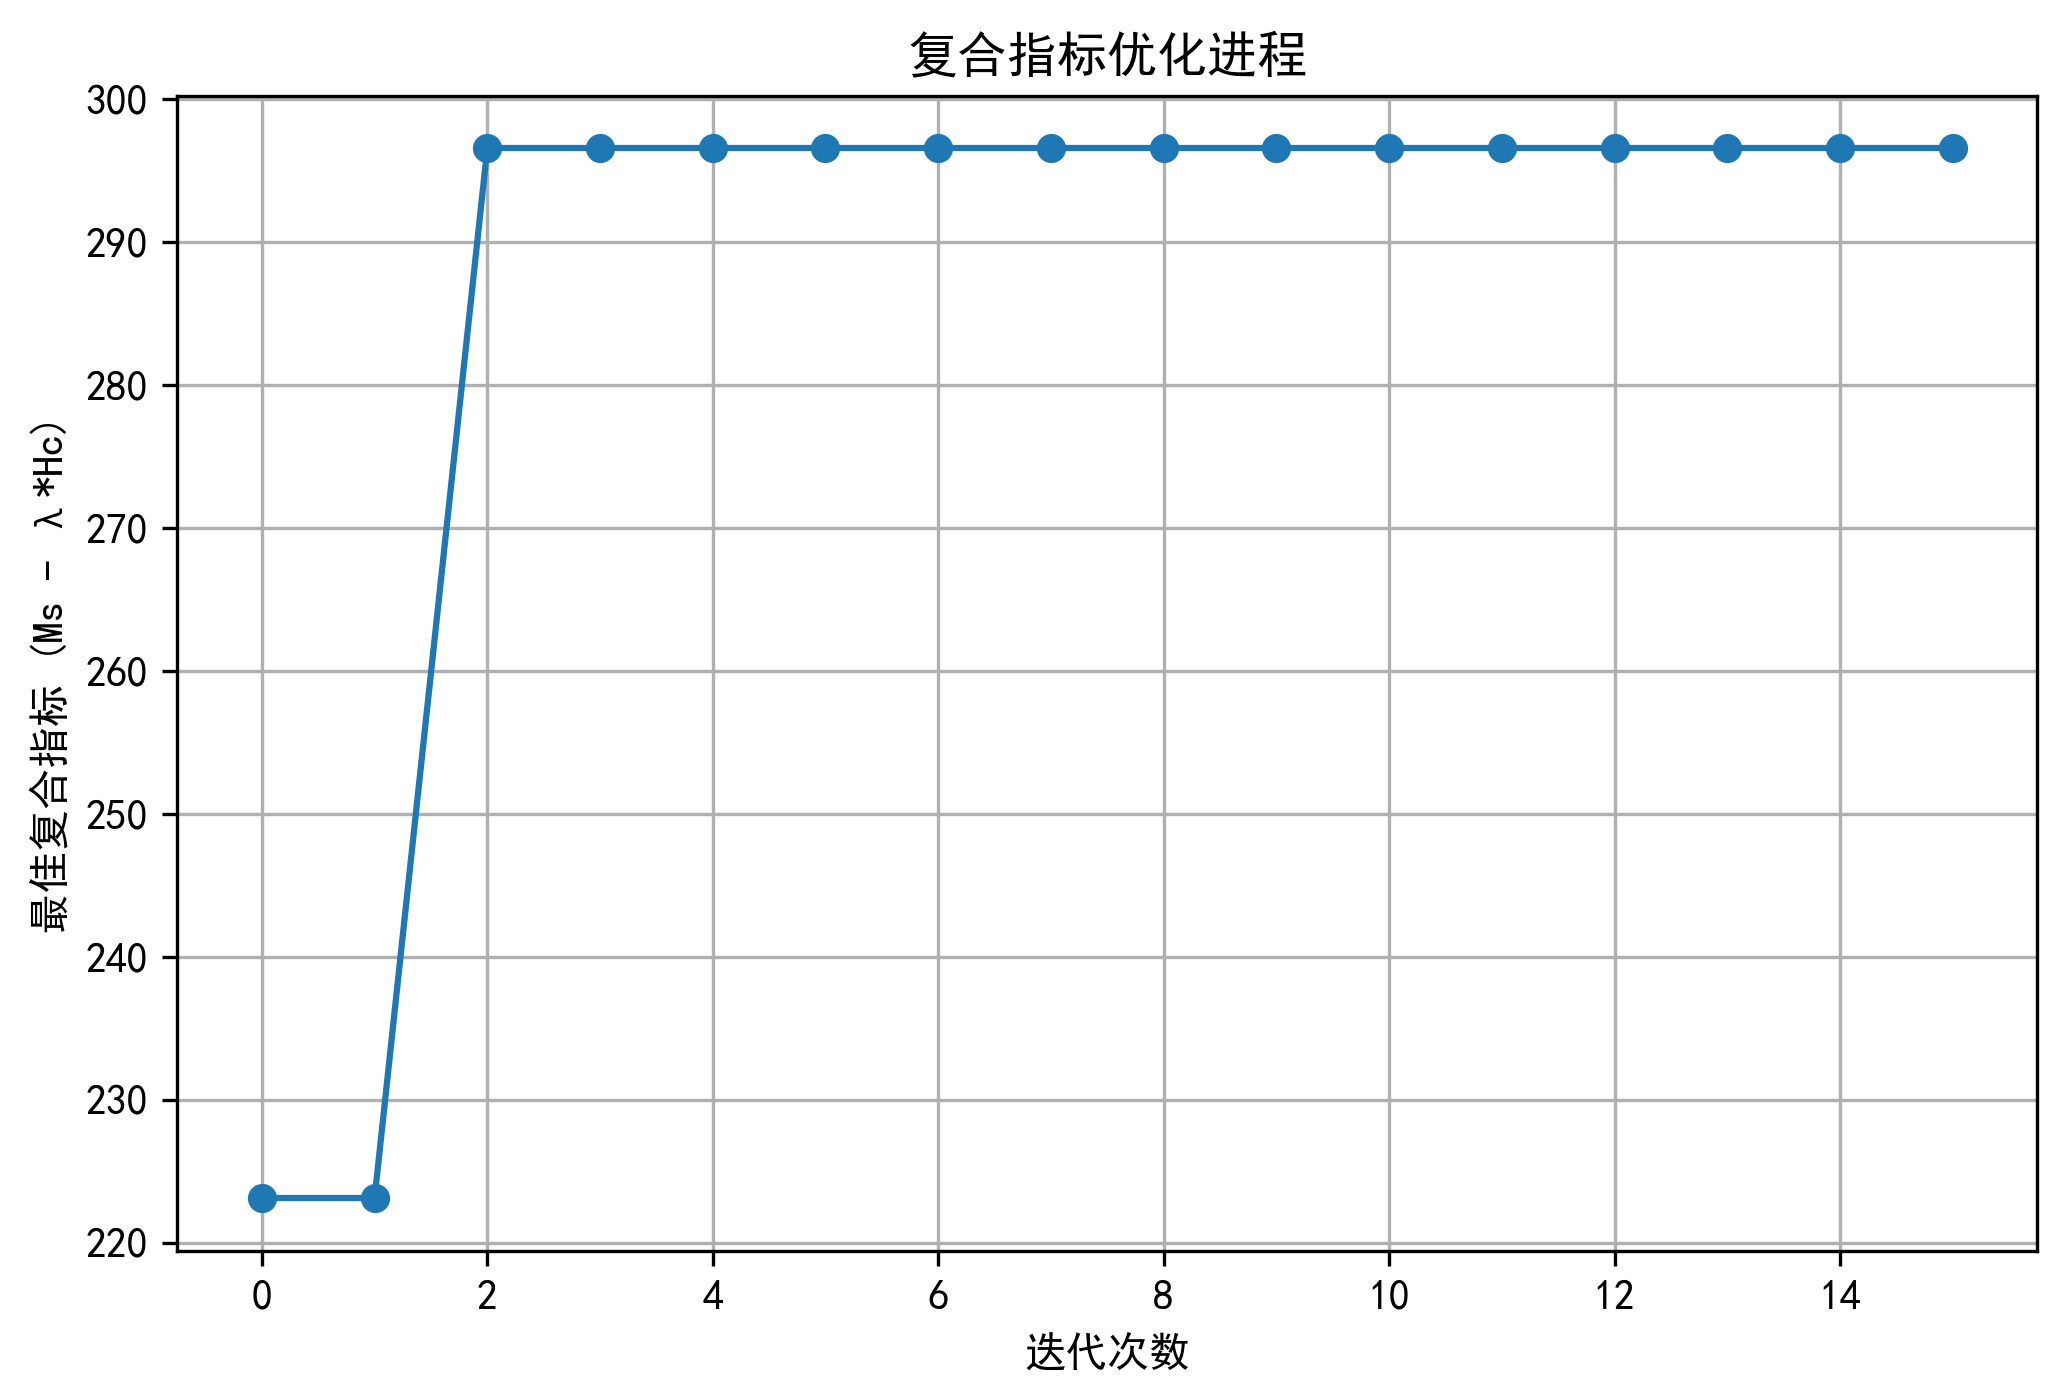

In [25]:
# 可视化优化过程
plt.figure(figsize=(8, 5))
plt.plot(range(iterations+1), iteration_best, marker='o', linestyle='-')
plt.xlabel('迭代次数')
plt.ylabel('最佳复合指标 (Ms - λ*Hc)')
plt.title('复合指标优化进程')
plt.grid(True)
plt.savefig('优化进程.png')
plt.show()

In [26]:
# 输出最终结果
best_idx = np.argmax(y_train['Ms'] - lambda_param * y_train['Hc'])
print("\n最优结果：")
print("特征组合：")
print(x_train.iloc[best_idx])
print(f"Ms: {y_train.iloc[best_idx]['Ms']:.2f}")
print(f"Hc: {y_train.iloc[best_idx]['Hc']:.2f}")
print(f"复合指标: {y_train.iloc[best_idx]['Ms'] - lambda_param*y_train.iloc[best_idx]['Hc']:.2f}")


最优结果：
特征组合：
Fe              71.40
Si               0.00
B               16.91
Nb               0.00
Zr               0.00
Cu               0.00
Ni               0.00
C                0.00
P               22.53
Co              22.51
Gd               0.00
Mo               0.00
Al               9.86
Y                0.00
Mn               0.00
Cr               0.00
Ta               0.00
DO3              1.00
BCC              1.00
FCC              0.00
HCP              1.00
Orthorhombic     1.00
hexagonal        0.00
Tetragonal       0.00
Name: 66, dtype: float64
Ms: 518.41
Hc: 443.62
复合指标: 296.60
